In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import hdbscan
import seaborn as sns
import scipy.optimize as opt

In [2]:
# Calculate coordinates from lattice vectors a, b and indices
def calc_coords(zero, a, b, indices):
    coefficients = np.array((a, b))
    return zero + np.dot(indices, coefficients)

# Helper function to generate grids
def peak_grid(zero, v1, v2, xes, yes, delta, exclude=()):
    zero = np.array(zero)
    v1 = np.array(v1)
    v2 = np.array(v2)
    exclude = np.array(exclude)
    i, j = np.meshgrid(xes, yes)
    indices = np.concatenate(np.array((i, j)).T)
    select = np.ones_like(indices[:,0], dtype=np.bool)
    for e in exclude:
        # Only include values where at least one is different from the exclude list
        select *= (np.not_equal(indices[:,0], e[0]) + np.not_equal(indices[:,1], e[1]))
    indices = indices[select]
    d = np.random.randn(*indices.shape) * delta
    coords = d + calc_coords(zero, v1, v2, indices)
    return coords

# Helper function to filter grids
def ring_filter(coords, center, r1, r2):
    distances = np.linalg.norm(center - coords, axis=1)
    select = (distances >= r1) * (distances < r2)
    return(coords[select])

# accept list of polar vectors, return list of cartesian vectors
def make_cartesian(polar):
    xes = np.cos(polar[:,1]) * polar[:, 0]
    yes = np.sin(polar[:,1]) * polar[:, 0]
    return np.array((xes, yes)).T
    
# accept list of cartesian vectors, return list of polar vectors
def make_polar(cartesian):
    ds = np.linalg.norm(cartesian, axis=1)
    alphas = np.arctan2(cartesian[:,1], cartesian[:,0])
    return np.array((ds, alphas)).T

# Test case for correct math
v = np.array([[2, 3], [7, 9]])
assert(np.allclose(v, make_cartesian(make_polar(v))))

In [3]:
# Make a bunch of grids with different characteristics
coords_1 = ring_filter(
    peak_grid(
        zero=(0.01,0.01),
        v1=(0.7, 0.3), 
        v2=(0.7, -0.4), 
        xes=np.arange(-5, 5), 
        yes=np.arange(-5, 5), 
        delta=0.01),
    center=(0,0), 
    r1=0, 
    r2=3
)

coords_2 = ring_filter(
    ring_filter(
        peak_grid(
            zero=(-0.02,0.01),
            v1=(0.5, 0.4), 
            v2=(0.3, -0.9), 
            xes=np.arange(-5, 5), 
            yes=np.arange(-5, 5), 
            delta=0.01,
            exclude=[(0,0)]
        ),
        center=(3,3), 
        r1=3, 
        r2=4
    ),
    center=(0,0),
    r1=0,
    r2=3
)

coords_3 = np.array([
    [0.34, 2.256],
    [1.76, -1.3]
])

coords_4 = ring_filter(
    ring_filter(
        peak_grid(
            zero=(0.02,-0.01),
            v1=(0.6, 0.4), 
            v2=(0.4, -0.9), 
            xes=np.arange(-5, 5), 
            yes=np.arange(-5, 5), 
            delta=0.01,
            exclude=[(0,0)]
        ),
        center=(-3,3), 
        r1=3, 
        r2=5
    ),
    center=(0,0),
    r1=0,
    r2=3.5 
)

coords_5 = ring_filter(
    peak_grid(
        zero=(0.01,-0.01),
        v1=(0.2, 0.3), 
        v2=(0.3, -0.2), 
        xes=np.arange(-5, 5), 
        yes=np.arange(-5, 5), 
        delta=0.01,
        exclude=[(0,0)]
    ),
    center=(0,0), 
    r1=0, 
    r2=2
)
indices = np.unique(np.random.randint(0, len(coords_5), 15))
coords_5 = coords_5[indices]

# Make a bunch of grids with different characteristics
coords_6 = ring_filter(
    peak_grid(
        zero=(-0.02,-0.02),
        v1=(0.9, 0.8), 
        v2=(0.7, -0.2), 
        xes=np.arange(-2, 2), 
        yes=np.arange(-2, 2), 
        delta=0.01,
        exclude=[(0,0)]
    ),
    center=(0,0), 
    r1=0, 
    r2=1.3
)

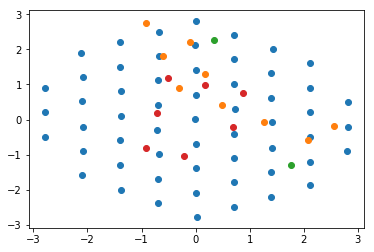

In [4]:
fig, axes = plt.subplots()
axes.scatter(coords_1[:,0], coords_1[:,1])
axes.scatter(coords_2[:,0], coords_2[:,1])
axes.scatter(coords_3[:,0], coords_3[:,1])
#axes.scatter(coords_4[:,0], coords_4[:,1])
#axes.scatter(coords_5[:,0], coords_5[:,1])
axes.scatter(coords_6[:,0], coords_6[:,1])

In [5]:
coords = np.concatenate((
    coords_1, 
    coords_2, 
    coords_3, 
#    coords_4, 
#    coords_5,
    coords_6
))
#coords = coords_5

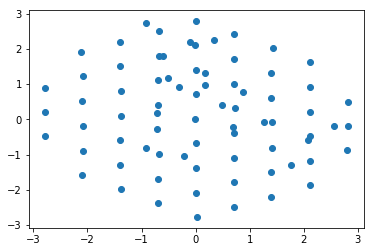

In [6]:
fig, axes = plt.subplots()
axes.scatter(coords[:,0], coords[:,1])

In [7]:
# Limits for connecting vector length to be considered a base vector candidate
limits = {
    'min_delta': 0.1,
    'max_delta': 2
}

def size_filter(polar, min_delta, max_delta):
    select = (polar[:,0] > min_delta) * (polar[:,0] < max_delta)
    return polar[select]

# The size filter only retains vectors with absolute values between min_delta
# and max_delta to avoid calculating for unwanted higher order or random smaller vectors
def make_polar_vectors(coords, min_delta=0, max_delta=np.float('inf')):
    # sort by x coordinate so that we have always positive x difference vectors
    sort_indices = np.argsort(coords[:,0])
    coords = coords[sort_indices]
    i, j = np.mgrid[0:len(coords), 0:len(coords)]
    selector = j > i
    deltas = coords[j[selector]] - coords[i[selector]]
    polar = make_polar(deltas)
    return size_filter(polar, min_delta, max_delta)



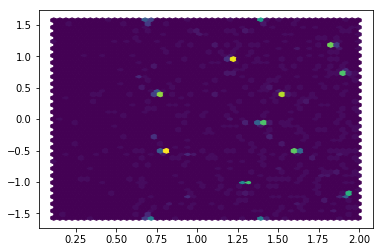

In [8]:
vectors = make_polar_vectors(coords, **limits)
fig, axes = plt.subplots()
axes.hexbin(vectors.T[0], vectors.T[1], gridsize=50)

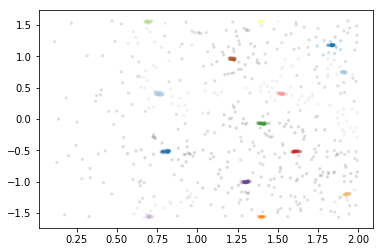

In [9]:
vectors = make_polar_vectors(coords, **limits)

# These settings should be fairly tight, throwing away
# anything that is fluffy or poorly populated
# But not too tight to still match if there are in the order of 10 points
# to avoid direct matching (expensive for many points)
def make_config(points):
    return {
        'min_cluster_size': max(len(points)//4, 2),
        'min_samples': max(len(points)//20, 1)
    }

params = make_config(coords)
clusterer = hdbscan.HDBSCAN(**params).fit(vectors)
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*vectors.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [10]:
# Use clustering to find potential candidates for lattice vectors.
# We rely on the clusterer and its settings to give us tight and well-populated clusters.
# Then we calculate mean and standard deviation for each cluster
# and then filter again for tightness.
# In the end we return the shortest matches.
def cluster_candidates(points, min_delta=0, max_delta=np.float('inf')):
    clusterer = hdbscan.HDBSCAN(**make_config(points))
    vectors = make_polar_vectors(points, min_delta=min_delta, max_delta=max_delta)
    clusterer.fit(vectors)
    labels = clusterer.labels_
    cand = []
    for cluster in range(max(labels) + 1):
        selector = labels == cluster
        v = vectors[selector]
        weights = clusterer.probabilities_[selector]
        std = v.std(axis=0)
        fom = np.linalg.norm(std)
        # FIXME magic number, make user parameter
        if fom > 0.3:
            # print("too fuzzy")
            continue
        mean = np.average(v, axis=0, weights=weights)
        cand.append(mean)
    # return the shortest candidate vectors
    # FIXME magic number 5
    return np.array(sorted(cand, key=lambda d: d[0])[:5])

In [11]:
# Very slow bruteforce method to find matches that don't have any pair of
# points connected directly by a lattice vector
# This situation is rarely encountered in real data, and
# in those cases a good lattice match is near impossible anyway.

def bruteforce_candidates(v1, v2, min_delta, max_delta, indexrange):
    # Find lattice vectors a, b to express v1, v2 
    # for a range of speculative indices
    aas = []
    bbs = []
    for i in range(0, indexrange):
        for j in range(0, indexrange):
            for k in range(0, indexrange):
                for l in range(0, indexrange):
                    coefficients = np.array([
                        (i, j),
                        (k, l)
                    ])
                    target = np.array((v1, v2)).T
                    try:
                        x = np.linalg.solve(coefficients, target)
                    except np.linalg.LinAlgError:
                        continue
                    a, b = x.T
                    aas.append(a)
                    bbs.append(b)
    result = make_polar(np.unique(np.concatenate((np.array(aas), np.array(bbs))), axis=0))
    return size_filter(result, min_delta, max_delta)

# Go through point list and generate speculative lattice vectors for all pairs of
# connecting vectors
def all_bruteforce(points, min_delta, max_delta, indexrange):
    result = []
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            for k in range(j+1, len(points)):
                result.append(
                    bruteforce_candidates(
                        points[i] - points[j], 
                        points[i] - points[k], 
                        min_delta, max_delta, indexrange
                    )
                )
    return np.unique(np.concatenate(result), axis=0)
    
#points = np.array([
#    (0, 0),
#    (7, 0),
#    (0, 7),
#    (3, 2)
#]
#)
    
#all_bruteforce(
#    points,
#    0,
#    3,
#    2
#)

In [12]:
def candidates(points, min_delta, max_delta):
    polar_vectors = []
    # Enough "flesh" to cluster
    # FIXME magic number
    if len(points) > 10:
        # Get some candidates
        polar_vectors = cluster_candidates(points, min_delta=min_delta, max_delta=max_delta)
    # Not enough candidates found, use all pairwise vectors as candidates
    # FIXME magic number
    # Tighter vector limits mean less candidates from clustering
    # Adjust as needed because the full match is slow for too many points
    if len(polar_vectors) < 3:
        if len(points) > 10:
            print("WARNING matching many points directly: ", len(points))
        polar_vectors = make_polar_vectors(points, min_delta=min_delta, max_delta=max_delta)
        # Brute force is too slow
        # polar_vectors = all_bruteforce(points, min_delta, max_delta, 2)
    return polar_vectors

In [13]:
# Find indices to express each point as sum of lattice vectors from zero point
# This could solve for arbitrarily many points, i.e. frame stacks instead of frame by frame
# With that the algorithm could actually match entire frame collections at once
def vector_solver(points, zero, a, b):
    coefficients = np.array((a, b)).T
    target = points - zero
    result = np.linalg.solve(coefficients, target.T).T
    return result

In [14]:
# In the real world would be the brightest peak or user input
zero = np.array((0, 0))

class NotFoundException(Exception): pass

# Find points that can be generated from the lattice vectors with near integer indices
# Return matched points, corresponding indices, and remainder
def match_all(points, zero, a, b):
    indices = vector_solver(points, zero, a, b)
    rounded = np.around(indices)
    errors = np.linalg.norm(np.absolute(indices - rounded), axis=1)
    # FIXME magic number, make user parameter
    matched_selector = (errors < 0.1)
    matched = points[matched_selector]
    matched_indices = rounded[matched_selector].astype(np.int)
    remainder = points[np.invert(matched_selector)]
    return (matched, matched_indices, remainder)

# Try out all combinations of polar_vectors and
# see which one generates most matches
def do_match(points, zero, polar_vectors):
    match_matrix = {}
    # we test all pairs of candidate vectors
    # and populate match_matrix
    for i in range(len(polar_vectors)):
        for j in range(i+1, len(polar_vectors)):
            a = polar_vectors[i]
            b = polar_vectors[j]
            angle_difference = abs(a[1] - b[1])
            if angle_difference < np.pi/5 or angle_difference > np.pi*4/5:
                # too collinear, not good lattice vectors
                continue
            a, b = make_cartesian(np.array([a, b]))
            match = match_all(points, zero, a, b)
            # At least three points matched
            if len(match[0]) > 2:
                match_matrix[(i, j)] = match
    return match_matrix
  
# Find the pair of lattice vectors that generates most matches
# Return vectors and additional info about the match
def find_best_vector_match(points, candidates, min_delta, max_delta):
    match_matrix = do_match(points, zero, candidates)
    if match_matrix:
        # we select the entry with highest number of matches
        candidate_index, match = sorted(match_matrix.items(), key=lambda d: len(d[1][1]), reverse=True)[0]
        polar_a = candidates[candidate_index[0]]
        polar_b = candidates[candidate_index[1]]
        a, b = make_cartesian(np.array([polar_a, polar_b]))
        return (a, b, match)
    else:
        raise NotFoundException
        
def optimize(zero, a, b, matched, matched_indices):    
    # The minimizer expects a flat array, so we disassemble the vectors
    z1, z2 = zero
    a1, a2 = a
    b1, b2 = b

    def error_function(vec):
        # ... and reassemble them here
        z1, z2, a1, a2, b1, b2 = vec
        zero = np.array((z1, z2))
        a = np.array((a1, a2))
        b = np.array((b1, b2))
        errors = matched - calc_coords(zero, a, b, matched_indices)
        error = (errors**2).sum()
        return error
    
    x0 = np.array((z1, z2, a1, a2, b1, b2))
    res = opt.minimize(error_function, x0=x0)
    
    z1, z2, a1, a2, b1, b2 = res.x
    
    new_zero = np.array((z1, z2))
    new_a = np.array((a1, a2))
    new_b = np.array((b1, b2))

    return np.array((new_zero, new_a, new_b))

# In the real world, this would distinguish more between finding good candidates
# from sum frames or region of interest
# and then match to individual frames
# The remainder of all frames could be thrown together for an additional round of matching
# to find faint and sparse peaks.
def find_all_matches(points, min_delta=0, max_delta=np.float('inf')):
    matches = []
    remainder = []
    while True:
        # First, find good candidate
        # Expensive operation, should be done on smaller sample
        # or sum frame result, at least for first passes to match majority
        # of peaks
        polar_candidate_vectors = candidates(points, min_delta, max_delta)
        try:
            tmp = find_best_vector_match(points, polar_candidate_vectors, min_delta, max_delta)
            a, b, (matched, matched_indices, remainder) = tmp
            opt_zero, a, b = optimize(zero, a, b, matched, matched_indices)
        except NotFoundException as e:
            #print("no match found:\n", points)
            break
        
        # Now, match more and optimize again
        # Not so expensive, could be done for much larger point list
        # Two passes since a better optimization result matches more points, in particular
        # far-out points that are good support points for the optimizer
        for i in range(2):            
            (matched, matched_indices, remainder) = match_all(points, opt_zero, a, b)
            opt_zero, a, b = optimize(opt_zero, a, b, matched, matched_indices)
            
        matches.append((opt_zero, a, b, matched, matched_indices))
        # doesn't span a lattice
        if len(remainder) < 4:
            #print("doesn't span a lattice")
            break
        if len(matched) == 0:
            #print("no endless loop")
            break
        points = remainder
        # We always include the zero point because all lattices have it in 
        # common and we filter it out each time
        # Gives additional point to match!
        points = np.append(points, [zero], axis=0)
    return (matches, remainder)

In [15]:
%timeit (matches, remainder) = find_all_matches(coords, **limits)

99.3 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# %prun (matches, remainder) = find_all_matches(coords, **limits)
(matches, remainder) = find_all_matches(coords, **limits)

Lattices:
[0.01080961 0.00974385] [0.70038244 0.29987467] [ 0.69956067 -0.39887222] 58
[-0.00534005 -0.01399033] [0.45187314 0.40206216] [ 0.70246096 -0.19405614] 11
[-0.00735125  0.00561266] [ 0.30063289 -0.90548061] [0.49077934 0.40202896] 6
Remainder:
 [[ 0.34   2.256]
 [ 1.76  -1.3  ]]


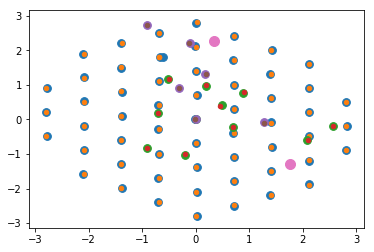

In [17]:
print("Lattices:")
for (opt_zero, a, b, matched, matched_indices) in matches:
    print(opt_zero, a, b, len(matched))
    plt.scatter(matched.T[0], matched.T[1], s=60)
    calc = calc_coords(opt_zero, a, b, matched_indices)
    plt.scatter(calc.T[0], calc.T[1], s=20)
if len(remainder) > 0:
    plt.scatter(remainder.T[0], remainder.T[1], s=100)
    print("Remainder:\n", remainder)
else:
    print("No remainder")